https://medium.com/towards-data-science/approaching-time-series-with-a-tree-based-model-87c6d1fb6603

https://medium.com/dataman-in-ai/tree-based-xgb-lightgbm-and-catboost-models-for-multi-period-time-series-probabilistic-6b12d1500779

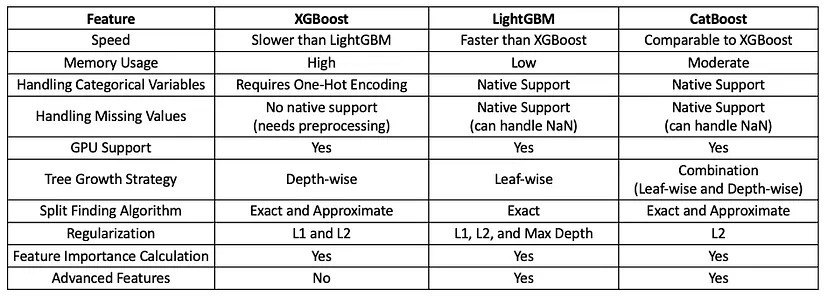

### **Data Preparation for Time Series Using Tree-Based Models (One-Liners)**  

1. **Create Lag Features** – Convert past observations into input features (e.g., `Lag_1`, `Lag_2`, …).  
2. **Rolling Window Features** – Compute moving averages, rolling sums, and standard deviations.  
3. **Differencing** – Use first-order or seasonal differencing to remove trends.  
4. **Datetime Features** – Extract day, month, quarter, year, and holiday indicators.  
5. **Categorical Encoding** – Convert categorical time-based features (e.g., day of the week) into numerical form.  
6. **Trend Features** – Add cumulative sum or exponential weighted moving average (EWMA).  
7. **Fourier Transform** – Encode seasonality using sine and cosine transformations.  
8. **Exogenous Variables** – Include additional predictors like weather, sales events, and economic indicators.  
9. **Target Encoding** – Encode categorical time-based features using historical averages.  
10. **Train-Test Split by Time** – Always split sequentially to avoid data leakage.  


# <a id='5' href=#1 ><h1 style="font-family: garamond; font-size: 40px; font-style: normal; letter-spacing: 3px; background-color: #f6f5f5; color: #003f88; border-radius: 50px; padding: 10px 20px; text-align: center; box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.2);">Import Libraries 🧰


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import optuna

# <a id='5' href=#1 ><h1 style="font-family: garamond; font-size: 40px; font-style: normal; letter-spacing: 3px; background-color: #f6f5f5; color: #003f88; border-radius: 50px; padding: 10px 20px; text-align: center; box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.2);">Stock Data Download 📈

In [ ]:
ticker = 'MYOR.JK'
start_date = '2000-11-22'
end_date = '2024-10-31'
stock_data = yf.download(ticker, start=start_date, end=end_date)
stock_data.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


# <a id='5' href=#1 ><h1 style="font-family: garamond; font-size: 40px; font-style: normal; letter-spacing: 3px; background-color: #f6f5f5; color: #003f88; border-radius: 50px; padding: 10px 20px; text-align: center; box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.2);">Data Split 📊

In [ ]:
train_mask = (stock_data['Date'] >= '2000-11-22') & (stock_data['Date'] <= '2019-11-25')
val_mask = (stock_data['Date'] >= '2019-11-26') & (stock_data['Date'] <= '2022-05-13')
test_mask = (stock_data['Date'] >= '2022-05-17') & (stock_data['Date'] <= '2024-10-31')

train_data = stock_data[train_mask]
val_data = stock_data[val_mask]
test_data = stock_data[test_mask]

# <a id='5' href=#1 ><h1 style="font-family: garamond; font-size: 40px; font-style: normal; letter-spacing: 3px; background-color: #f6f5f5; color: #003f88; border-radius: 50px; padding: 10px 20px; text-align: center; box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.2);">Data Normalization 🔄

In [ ]:
scaler = StandardScaler()
train_data['Close'] = scaler.fit_transform(train_data[['Close']])
val_data['Close'] = scaler.transform(val_data[['Close']])
test_data['Close'] = scaler.transform(test_data[['Close']])

C:\Users\Nabila Mumtaz\AppData\Local\Temp\ipykernel_35916\1253747901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Close'] = scaler.fit_transform(train_data[['Close']])
C:\Users\Nabila Mumtaz\AppData\Local\Temp\ipykernel_35916\1253747901.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['Close'] = scaler.transform(val_data[['Close']])
C:\Users\Nabila Mumtaz\AppData\Local\Temp\ipykernel_35916\1253747901.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

# <a id='5' href=#1 ><h1 style="font-family: garamond; font-size: 40px; font-style: normal; letter-spacing: 3px; background-color: #f6f5f5; color: #003f88; border-radius: 50px; padding: 10px 20px; text-align: center; box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.2);">FeatureEngineering 🔧

In [ ]:
def create_features(data, number_lags=7):
    for lag in range(1, number_lags + 1):
        data[f'lag_{lag}'] = data['Close'].shift(lag)
    data['target_t+1'] = data['Close'].shift(-1)
    data['target_t+2'] = data['Close'].shift(-2)
    return data.dropna().reset_index(drop=True)

train_data = create_features(train_data)
val_data = create_features(val_data)
test_data = create_features(test_data)

C:\Users\Nabila Mumtaz\AppData\Local\Temp\ipykernel_35916\969888643.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'lag_{lag}'] = data['Close'].shift(lag)
C:\Users\Nabila Mumtaz\AppData\Local\Temp\ipykernel_35916\969888643.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'lag_{lag}'] = data['Close'].shift(lag)
C:\Users\Nabila Mumtaz\AppData\Local\Temp\ipykernel_35916\969888643.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

# <a id='5' href=#1 ><h1 style="font-family: garamond; font-size: 40px; font-style: normal; letter-spacing: 3px; background-color: #f6f5f5; color: #003f88; border-radius: 50px; padding: 10px 20px; text-align: center; box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.2);">DataPreparation 🧹

In [ ]:
X_train, y_train = train_data[[f'lag_{i}' for i in range(1, 8)]], train_data[['Close', 'target_t+1', 'target_t+2']]
X_val, y_val = val_data[[f'lag_{i}' for i in range(1, 8)]], val_data[['Close', 'target_t+1', 'target_t+2']]
X_test, y_test = test_data[[f'lag_{i}' for i in range(1, 8)]], test_data[['Close', 'target_t+1', 'target_t+2']]

# <a id='5' href=#1 ><h1 style="font-family: garamond; font-size: 40px; font-style: normal; letter-spacing: 3px; background-color: #f6f5f5; color: #003f88; border-radius: 50px; padding: 10px 20px; text-align: center; box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.2);">Random Forest Model

Random Forest - MAE: 51.8137, RMSE: 69.4963, MAPE: 0.0219


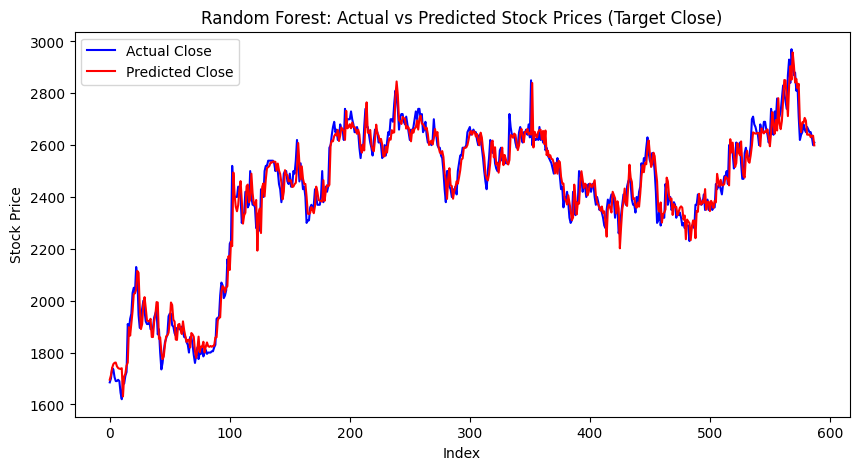

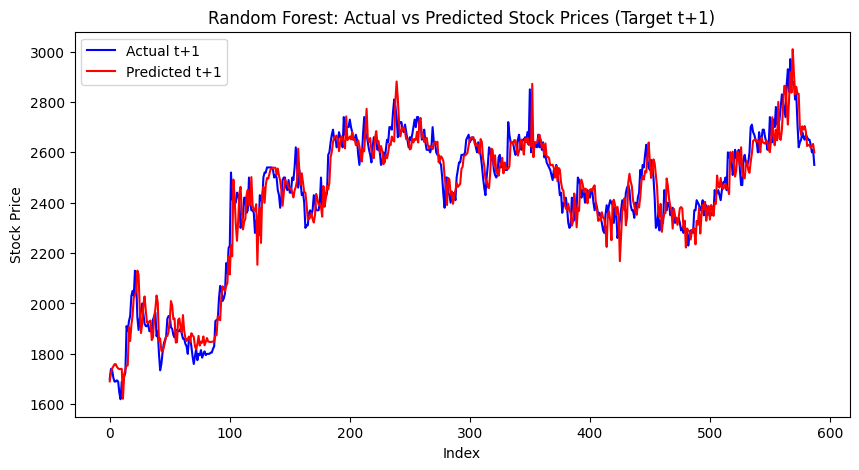

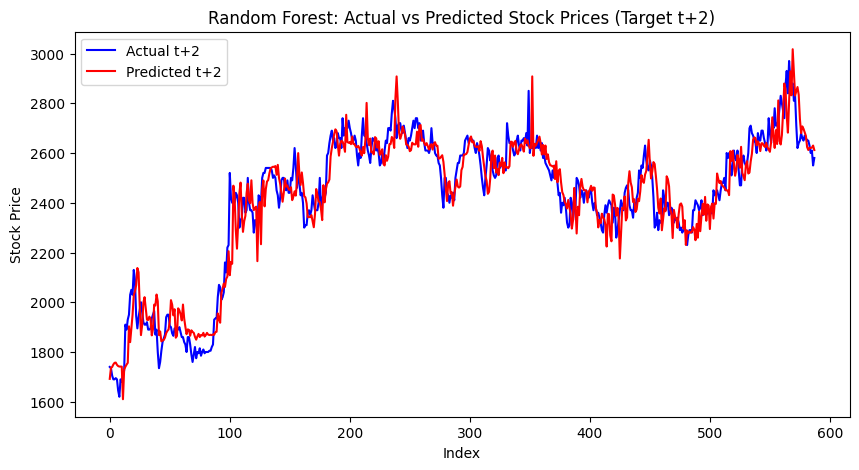

In [ ]:
# Model Random Forest untuk prediksi
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prediksi
y_test_pred = rf_model.predict(X_test)

# Denormalisasi hasil prediksi dan aktual
y_test_actual = scaler.inverse_transform(y_test)
y_test_pred_actual = scaler.inverse_transform(y_test_pred)

# Evaluasi model
mae = mean_absolute_error(y_test_actual, y_test_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_actual))
mape = mean_absolute_percentage_error(y_test_actual, y_test_pred_actual)

print(f"Random Forest - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}")

# Visualisasi hasil
targets = ['Close', 't+1', 't+2']
for i, target in enumerate(targets):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual[:, i], label=f'Actual {target}', color='blue')
    plt.plot(y_test_pred_actual[:, i], label=f'Predicted {target}', color='red')
    plt.title(f'Random Forest: Actual vs Predicted Stock Prices (Target {target})')
    plt.xlabel('Index')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

 # <a id='5' href=#1 ><h1 style="font-family: garamond; font-size: 40px; font-style: normal; letter-spacing: 3px; background-color: #f6f5f5; color: #003f88; border-radius: 50px; padding: 10px 20px; text-align: center; box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.2);">Tuned Random Forest

In [ ]:
# Fungsi untuk objective Optuna
def objective(trial):
    # Hyperparameters yang akan dituning
    n_estimators = trial.suggest_int('n_estimators', 100, 500, step=50)
    max_depth = trial.suggest_int('max_depth', 10, 100, step=10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_float('max_features', 0.1, 1.0, step=0.1)

    # Inisialisasi model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    # Training model
    model.fit(X_train, y_train)

    # Prediksi pada data validasi
    y_val_pred = model.predict(X_val)

    # Evaluasi menggunakan MAE pada target [Close, t+1, t+2]
    mae = mean_absolute_error(y_val, y_val_pred)

    return mae

# Mengurangi output log Optuna jika tidak diperlukan
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Optuna Study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Menampilkan hasil terbaik
print("Best hyperparameters:")
print(study.best_params)

# Training ulang dengan hyperparameter terbaik
best_params = study.best_params
rf_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Prediksi pada data test
y_test_pred = rf_model.predict(X_test)

# Denormalisasi hasil prediksi dan aktual
y_test_actual = scaler.inverse_transform(y_test)  # Denormalisasi target
y_test_pred_actual = scaler.inverse_transform(y_test_pred)  # Denormalisasi prediksi

# Evaluasi pada data test
mae = mean_absolute_error(y_test_actual, y_test_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_actual))
mape = mean_absolute_percentage_error(y_test_actual, y_test_pred_actual)

print(f"Random Forest (Tuned) - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}")

# Visualisasi hasil prediksi vs aktual
targets = ['Close', 't+1', 't+2']
for i, target in enumerate(targets):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual[:, i], label=f'Actual {target}', color='blue')
    plt.plot(y_test_pred_actual[:, i], label=f'Predicted {target}', color='red')
    plt.title(f'Random Forest (Tuned): Actual vs Predicted Stock Prices (Target {target})')
    plt.xlabel('Index')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


# <a id='5' href=#1 ><h1 style="font-family: garamond; font-size: 40px; font-style: normal; letter-spacing: 3px; background-color: #f6f5f5; color: #003f88; border-radius: 50px; padding: 10px 20px; text-align: center; box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.2);">Extra Trees Model

Extra Trees - MAE: 54.2354, RMSE: 72.1570, MAPE: 0.0229


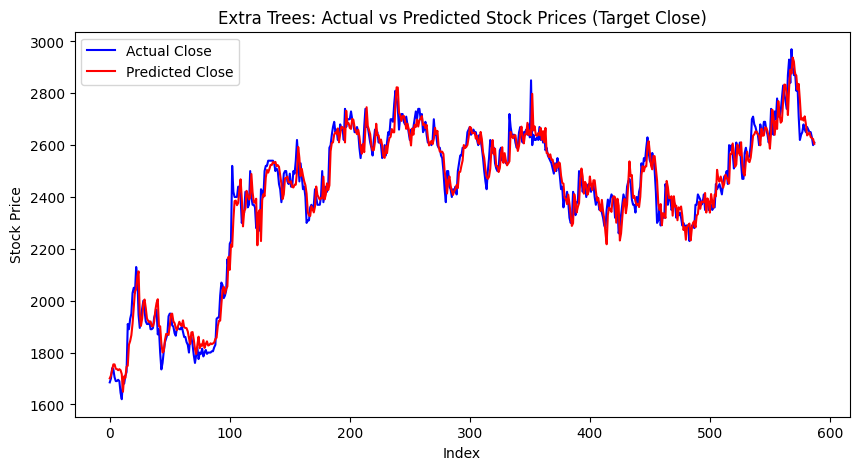

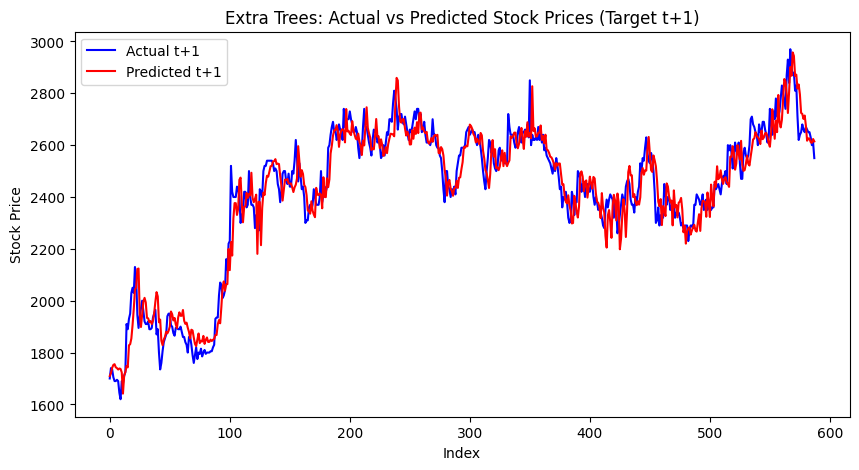

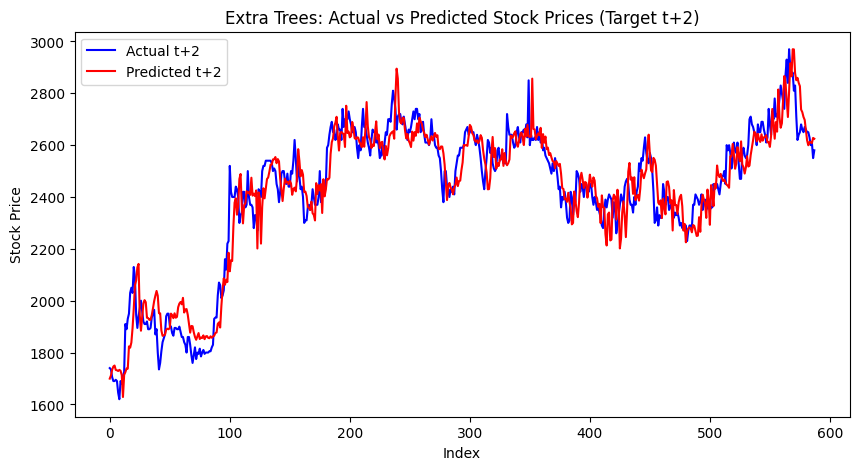

In [ ]:
# Inisialisasi model Extra Trees dengan default hyperparameter
et_model = ExtraTreesRegressor(random_state=42, n_jobs=-1)

# Training model
et_model.fit(X_train, y_train)

# Prediksi pada data test
y_test_pred = et_model.predict(X_test)

# Denormalisasi hasil prediksi dan data aktual
y_test_actual = scaler.inverse_transform(y_test)  # Denormalisasi target aktual
y_test_pred_actual = scaler.inverse_transform(y_test_pred)  # Denormalisasi prediksi

# Evaluasi kinerja model
mae = mean_absolute_error(y_test_actual, y_test_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_actual))
mape = mean_absolute_percentage_error(y_test_actual, y_test_pred_actual)

# Menampilkan hasil evaluasi
print(f"Extra Trees - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}")

# Visualisasi hasil prediksi vs data aktual untuk masing-masing target
targets = ['Close', 't+1', 't+2']
for i, target in enumerate(targets):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual[:, i], label=f'Actual {target}', color='blue')
    plt.plot(y_test_pred_actual[:, i], label=f'Predicted {target}', color='red')
    plt.title(f'Extra Trees: Actual vs Predicted Stock Prices (Target {target})')
    plt.xlabel('Index')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


# <a id='5' href=#1 ><h1 style="font-family: garamond; font-size: 40px; font-style: normal; letter-spacing: 3px; background-color: #f6f5f5; color: #003f88; border-radius: 50px; padding: 10px 20px; text-align: center; box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.2);"> Tuned Extra Trees

Best hyperparameters:
{'n_estimators': 100, 'max_depth': 95, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 1.0}
Extra Trees (Tuned) - MAE: 50.2282, RMSE: 67.0230, MAPE: 0.0212


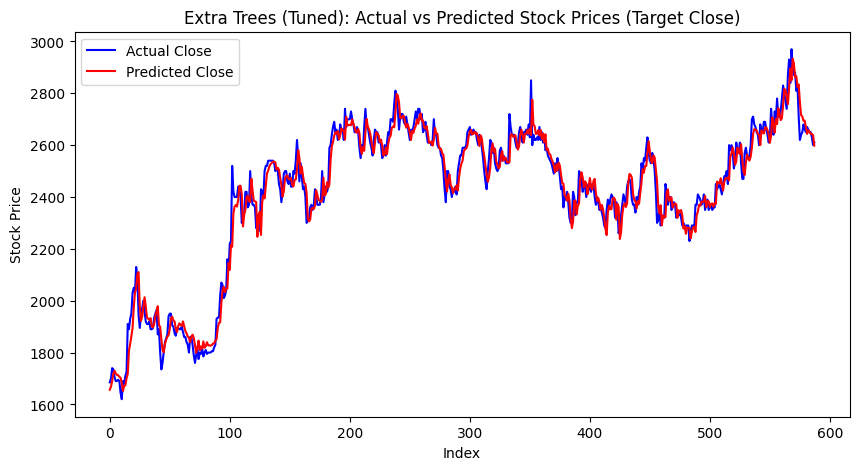

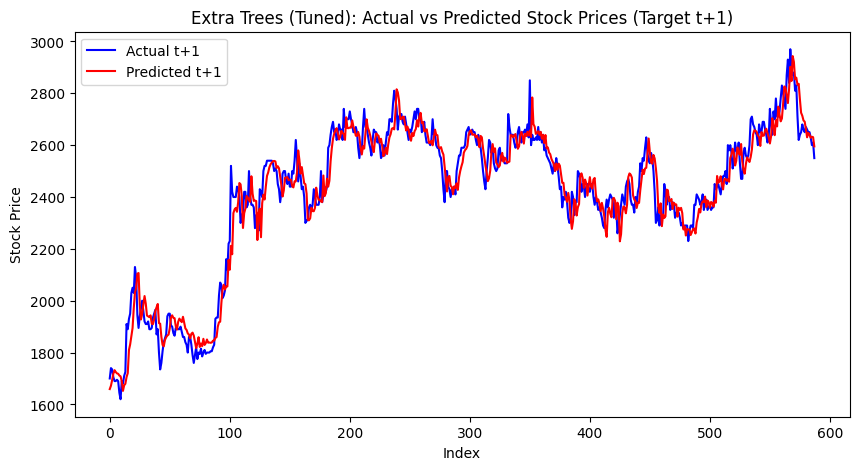

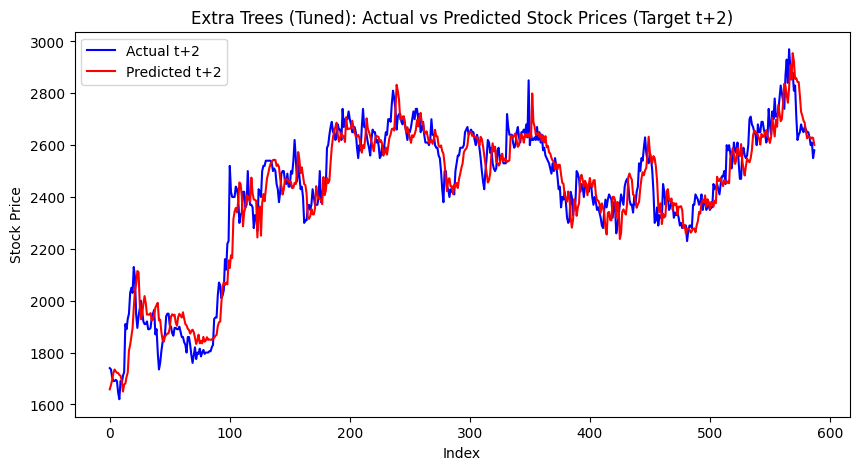

In [ ]:
# Fungsi untuk objective Optuna
def objective(trial):
    # Hyperparameters yang akan dituning
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=50)
    max_depth = trial.suggest_int('max_depth', 5, 100, step=5)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_float('max_features', 0.1, 1.0, step=0.1)

    # Inisialisasi model
    model = ExtraTreesRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    # Training model
    model.fit(X_train, y_train)

    # Prediksi pada data validasi
    y_val_pred = model.predict(X_val)

    # Evaluasi menggunakan MAE
    mae = mean_absolute_error(y_val, y_val_pred)

    return mae

# Mengurangi log Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Optuna Study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Menampilkan hasil terbaik
print("Best hyperparameters:")
print(study.best_params)

# Training ulang dengan hyperparameter terbaik
best_params = study.best_params
et_model = ExtraTreesRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42,
    n_jobs=-1
)

# Melatih model dengan hyperparameter terbaik
et_model.fit(X_train, y_train)

# Prediksi pada data test
y_test_pred = et_model.predict(X_test)

# Denormalisasi hasil prediksi dan aktual
y_test_actual = scaler.inverse_transform(y_test)  # Denormalisasi target aktual
y_test_pred_actual = scaler.inverse_transform(y_test_pred)  # Denormalisasi prediksi

# Evaluasi pada data test
mae = mean_absolute_error(y_test_actual, y_test_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_actual))
mape = mean_absolute_percentage_error(y_test_actual, y_test_pred_actual)

# Output evaluasi
print(f"Extra Trees (Tuned) - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}")

# Visualisasi hasil prediksi vs aktual
targets = ['Close', 't+1', 't+2']
for i, target in enumerate(targets):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual[:, i], label=f'Actual {target}', color='blue')
    plt.plot(y_test_pred_actual[:, i], label=f'Predicted {target}', color='red')
    plt.title(f'Extra Trees (Tuned): Actual vs Predicted Stock Prices (Target {target})')
    plt.xlabel('Index')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


# <a id='5' href=#1 ><h1 style="font-family: garamond; font-size: 40px; font-style: normal; letter-spacing: 3px; background-color: #f6f5f5; color: #003f88; border-radius: 50px; padding: 10px 20px; text-align: center; box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.2);">Catboost Model

In [ ]:
# Kolom target sesuai hasil y_train.columns
target_columns = ['Close', 'target_t+1', 'target_t+2']

# Inisialisasi variabel untuk menyimpan model, prediksi, dan error
models = {}
predictions = {}
errors = {}

# Denormalisasi data target
def denormalize(data):
    return scaler.inverse_transform(data.values.reshape(-1, 1))

# Melatih model untuk setiap target secara independen
for target in target_columns:
    print(f"Training model for {target}...")

    # Inisialisasi model CatBoost dengan parameter default
    catboost_model = CatBoostRegressor(random_state=42, verbose=0)

    # Melatih model pada target spesifik
    catboost_model.fit(X_train, y_train[target])

    # Simpan model
    models[target] = catboost_model

    # Prediksi untuk test set
    y_test_pred = catboost_model.predict(X_test)

    # Denormalisasi hasil prediksi dan aktual
    y_test_actual = denormalize(y_test[target])
    y_test_pred_actual = scaler.inverse_transform(y_test_pred.reshape(-1, 1))

    # Evaluasi performa model
    mae = mean_absolute_error(y_test_actual, y_test_pred_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_actual))
    mape = mean_absolute_percentage_error(y_test_actual, y_test_pred_actual)

    # Simpan hasil prediksi dan metrik error
    predictions[target] = y_test_pred_actual
    errors[target] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}

    # Output metrik error
    print(f"{target} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}")

    # Visualisasi hasil prediksi vs aktual
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual, label=f'Actual {target}', color='blue')
    plt.plot(y_test_pred_actual, label=f'Predicted {target}', color='red')
    plt.title(f'CatBoost: Actual vs Predicted Stock Prices ({target})')
    plt.xlabel('Index')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Ringkasan error
print("\nError Summary:")
for target, error_metrics in errors.items():
    print(f"{target}:")
    for metric, value in error_metrics.items():
        print(f"  {metric}: {value:.4f}")


# <a id='5' href=#1 ><h1 style="font-family: garamond; font-size: 40px; font-style: normal; letter-spacing: 3px; background-color: #f6f5f5; color: #003f88; border-radius: 50px; padding: 10px 20px; text-align: center; box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.2);"> Tuned Catboost


Tuning hyperparameters for Close...
Best parameters for Close: {'iterations': 900, 'depth': 7, 'learning_rate': 0.07439399002259975, 'l2_leaf_reg': 1.5825573916466855}
Close - MAE: 42.1647, RMSE: 56.2758, MAPE: 0.0178


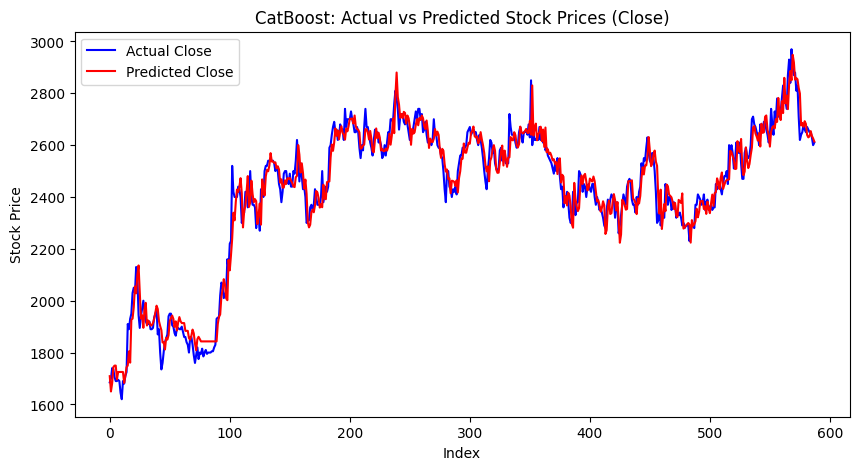


Tuning hyperparameters for target_t+1...
Best parameters for target_t+1: {'iterations': 900, 'depth': 4, 'learning_rate': 0.06829933050239012, 'l2_leaf_reg': 7.11307391063093}
target_t+1 - MAE: 52.0510, RMSE: 68.4078, MAPE: 0.0220


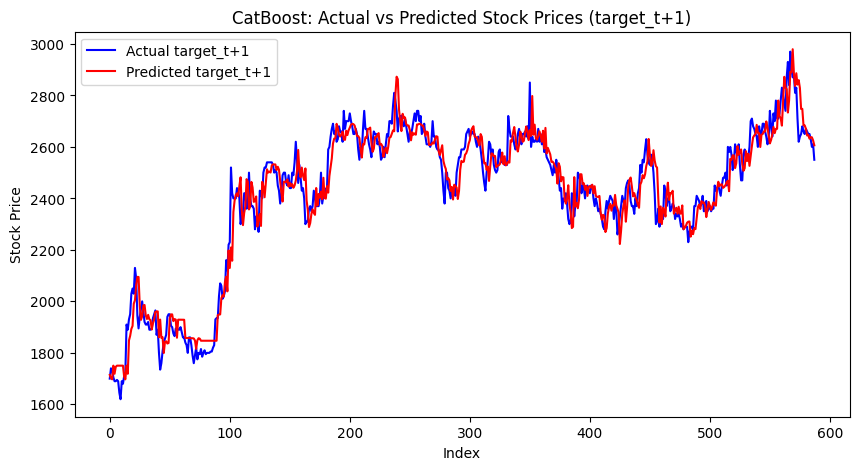


Tuning hyperparameters for target_t+2...
Best parameters for target_t+2: {'iterations': 400, 'depth': 4, 'learning_rate': 0.1926444786783698, 'l2_leaf_reg': 6.098689664055453}
target_t+2 - MAE: 64.8859, RMSE: 85.0536, MAPE: 0.0276


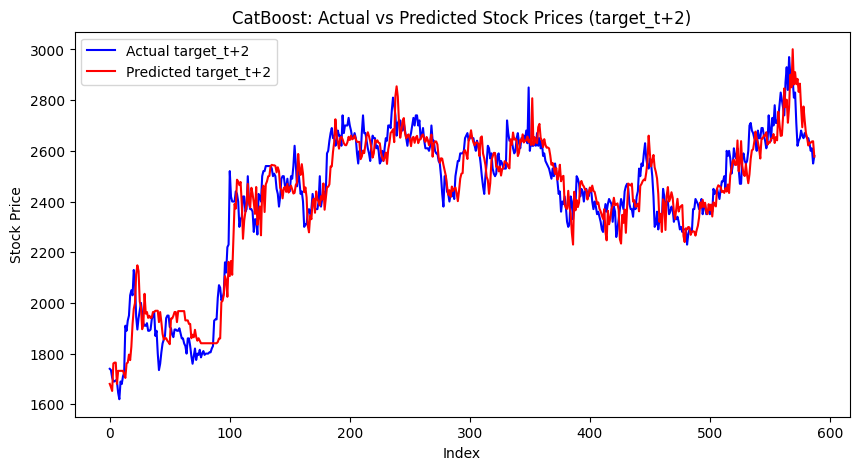


Error Summary:
Close:
  MAE: 42.1647
  RMSE: 56.2758
  MAPE: 0.0178
target_t+1:
  MAE: 52.0510
  RMSE: 68.4078
  MAPE: 0.0220
target_t+2:
  MAE: 64.8859
  RMSE: 85.0536
  MAPE: 0.0276


In [ ]:
# Kolom target
target_columns = ['Close', 'target_t+1', 'target_t+2']

# Variabel untuk menyimpan model, prediksi, dan error
models = {}
predictions = {}
errors = {}

# Fungsi denormalisasi data
def denormalize(data):
    return scaler.inverse_transform(data.values.reshape(-1, 1))

# Fungsi untuk objective Optuna
def objective(trial, target):
    # Hyperparameter yang akan dituning
    iterations = trial.suggest_int('iterations', 100, 1000, step=100)
    depth = trial.suggest_int('depth', 4, 12)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10)

    # Model CatBoost
    model = CatBoostRegressor(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        random_state=42,
        verbose=0
    )

    # Melatih model pada data training
    model.fit(X_train, y_train[target])

    # Prediksi pada data validasi
    y_val_pred = model.predict(X_val)

    # Evaluasi menggunakan MAE
    mae = mean_absolute_error(y_val[target], y_val_pred)
    return mae

# Tuning hyperparameter untuk setiap target
for target in target_columns:
    print(f"\nTuning hyperparameters for {target}...")

    # Membuat study Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, target), n_trials=50)

    # Menampilkan hyperparameter terbaik
    best_params = study.best_params
    print(f"Best parameters for {target}: {best_params}")

    # Melatih model dengan hyperparameter terbaik
    tuned_model = CatBoostRegressor(
        iterations=best_params['iterations'],
        depth=best_params['depth'],
        learning_rate=best_params['learning_rate'],
        l2_leaf_reg=best_params['l2_leaf_reg'],
        random_state=42,
        verbose=0
    )
    tuned_model.fit(X_train, y_train[target])

    # Simpan model
    models[target] = tuned_model

    # Prediksi pada data test
    y_test_pred = tuned_model.predict(X_test)

    # Denormalisasi hasil prediksi dan aktual
    y_test_actual = denormalize(y_test[target])
    y_test_pred_actual = scaler.inverse_transform(y_test_pred.reshape(-1, 1))

    # Evaluasi performa model
    mae = mean_absolute_error(y_test_actual, y_test_pred_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_actual))
    mape = mean_absolute_percentage_error(y_test_actual, y_test_pred_actual)

    # Simpan hasil prediksi dan metrik error
    predictions[target] = y_test_pred_actual
    errors[target] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}

    # Output metrik error
    print(f"{target} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}")

    # Visualisasi hasil prediksi vs aktual
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual, label=f'Actual {target}', color='blue')
    plt.plot(y_test_pred_actual, label=f'Predicted {target}', color='red')
    plt.title(f'CatBoost: Actual vs Predicted Stock Prices ({target})')
    plt.xlabel('Index')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Ringkasan error
print("\nError Summary:")
for target, error_metrics in errors.items():
    print(f"{target}:")
    for metric, value in error_metrics.items():
        print(f"  {metric}: {value:.4f}")


# <a id='5' href=#1 ><h1 style="font-family: garamond; font-size: 40px; font-style: normal; letter-spacing: 3px; background-color: #f6f5f5; color: #003f88; border-radius: 50px; padding: 10px 20px; text-align: center; box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.2);">XGBoost Model

XGBoost - MAE: 58.49058674576602, RMSE: 78.68884080549267, MAPE: 0.0249635375809998


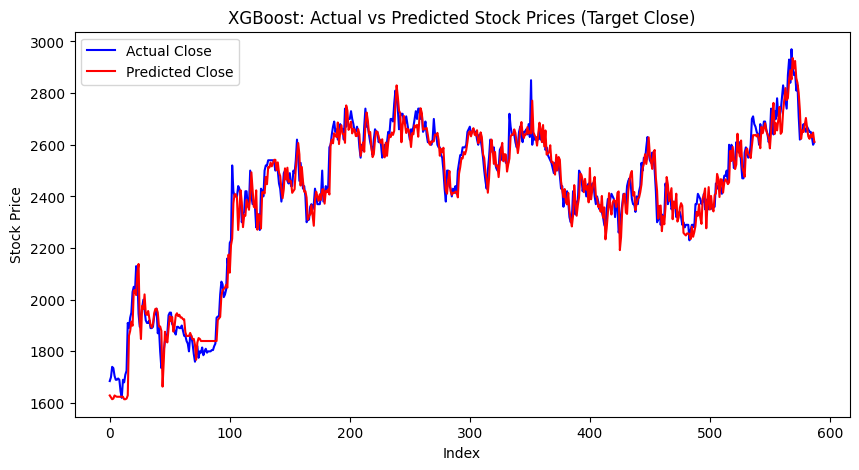

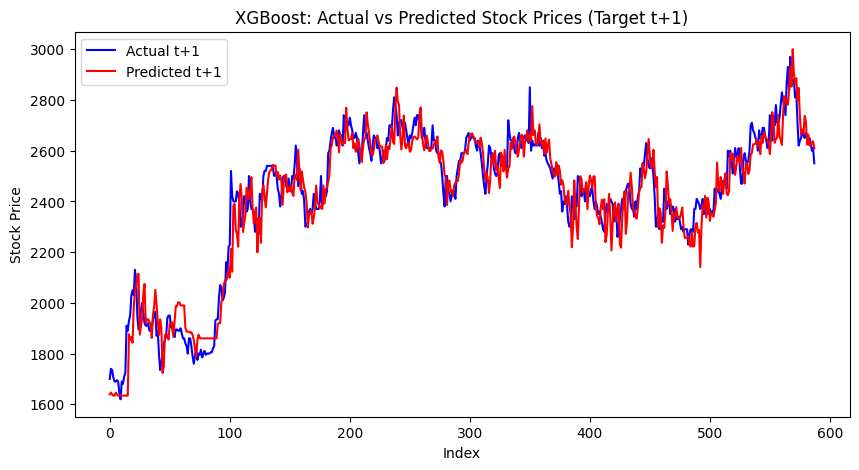

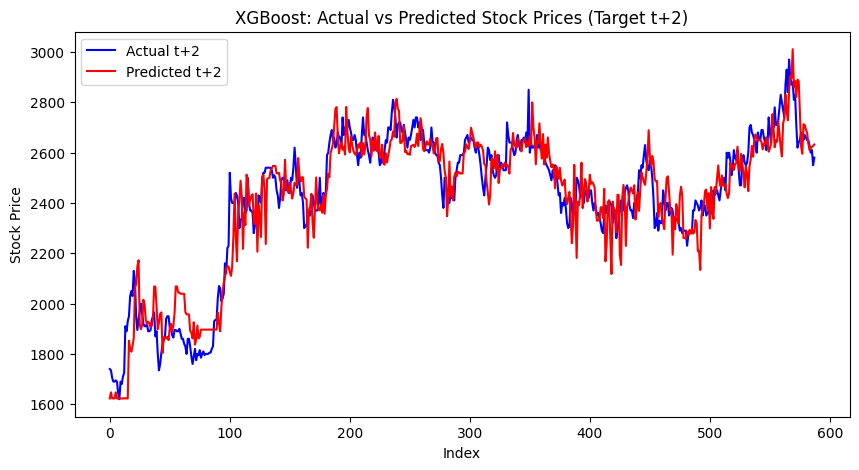

In [ ]:
# Model XGBoost
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Prediksi
y_test_pred_xgb = xgb_model.predict(X_test)

# Denormalisasi hasil prediksi dan aktual
y_test_actual_xgb = scaler.inverse_transform(y_test)
y_test_pred_actual_xgb = scaler.inverse_transform(y_test_pred_xgb)

# Evaluasi
mae_xgb = mean_absolute_error(y_test_actual_xgb, y_test_pred_actual_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_actual_xgb, y_test_pred_actual_xgb))
mape_xgb = mean_absolute_percentage_error(y_test_actual_xgb, y_test_pred_actual_xgb)

print(f"XGBoost - MAE: {mae_xgb}, RMSE: {rmse_xgb}, MAPE: {mape_xgb}")

# Visualisasi
for i, target in enumerate(['Close', 't+1', 't+2']):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual_xgb[:, i], label=f'Actual {target}', color='blue')
    plt.plot(y_test_pred_actual_xgb[:, i], label=f'Predicted {target}', color='red')
    plt.title(f'XGBoost: Actual vs Predicted Stock Prices (Target {target})')
    plt.xlabel('Index')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


# <a id='5' href=#1 ><h1 style="font-family: garamond; font-size: 40px; font-style: normal; letter-spacing: 3px; background-color: #f6f5f5; color: #003f88; border-radius: 50px; padding: 10px 20px; text-align: center; box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.2);"> Tuned XGboost

Best hyperparameters:
{'n_estimators': 108, 'max_depth': 3, 'learning_rate': 0.10109913171076092, 'colsample_bytree': 0.7658287092631969, 'subsample': 0.6084965957177305}
XGBoost (Tuned) - MAE: 50.83206889526644, RMSE: 68.7075892212376, MAPE: 0.021515564767046455


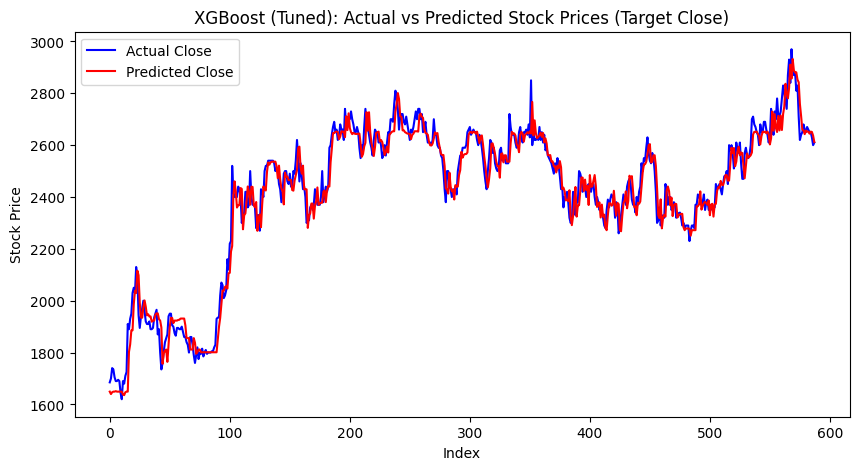

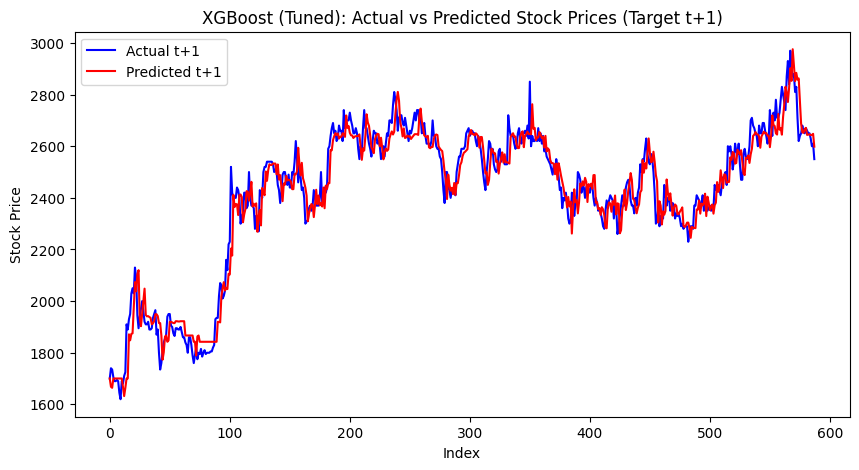

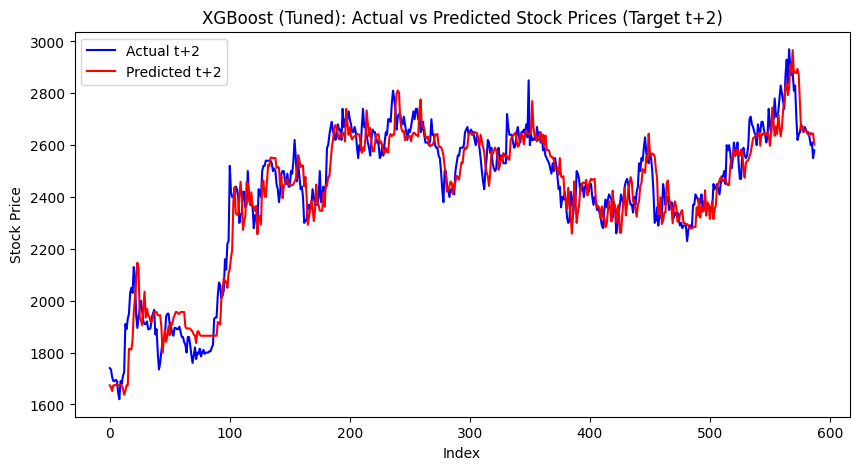

In [ ]:
# Fungsi untuk objective Optuna
def objective(trial):
    # Hyperparameters yang akan dituning
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 50)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)

    # Inisialisasi model
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        random_state=42
    )

    # Training model
    model.fit(X_train, y_train)

    # Prediksi pada data validation
    y_val_pred = model.predict(X_val)

    # Evaluasi menggunakan MAE
    mae = mean_absolute_error(y_val, y_val_pred)

    return mae

# Optuna Study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Menampilkan hasil terbaik
print("Best hyperparameters:")
print(study.best_params)

# Training ulang dengan hyperparameter terbaik
best_params = study.best_params
xgb_model = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    colsample_bytree=best_params['colsample_bytree'],
    subsample=best_params['subsample'],
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Prediksi pada data test
y_test_pred = xgb_model.predict(X_test)

# Denormalisasi hasil prediksi dan aktual
y_test_actual = scaler.inverse_transform(y_test)
y_test_pred_actual = scaler.inverse_transform(y_test_pred)

# Evaluasi pada data test
mae = mean_absolute_error(y_test_actual, y_test_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_actual))
mape = mean_absolute_percentage_error(y_test_actual, y_test_pred_actual)

print(f"XGBoost (Tuned) - MAE: {mae}, RMSE: {rmse}, MAPE: {mape}")

# Visualisasi hasil prediksi vs aktual
for i, target in enumerate(['Close', 't+1', 't+2']):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual[:, i], label=f'Actual {target}', color='blue')
    plt.plot(y_test_pred_actual[:, i], label=f'Predicted {target}', color='red')
    plt.title(f'XGBoost (Tuned): Actual vs Predicted Stock Prices (Target {target})')
    plt.xlabel('Index')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
